---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [1]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [2]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/rozasamyrkanova/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На семинаре была рассмотрена вот эта система.

![image.png](attachment:image.png)

Будем использовать универсальную систему тегирования universal_tagset 

In [3]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/rozasamyrkanova/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="tagset.png">

Мы имеем массив предложений пар (слово-тег)

In [4]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [5]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [6]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqdDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [7]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова
tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега с корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова с корпусе

Кол-во предложений:  57340


In [8]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

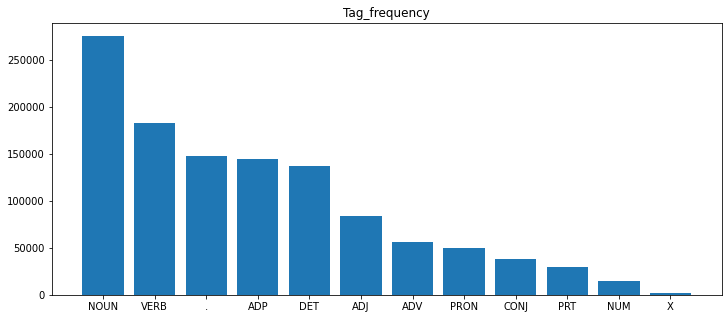

In [9]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [10]:
word_num

the           62713
,             58334
.             49346
of            36080
and           27915
              ...  
Crescent          1
Crimea            1
annex             1
legions           1
stupefying        1
Length: 56057, dtype: int64

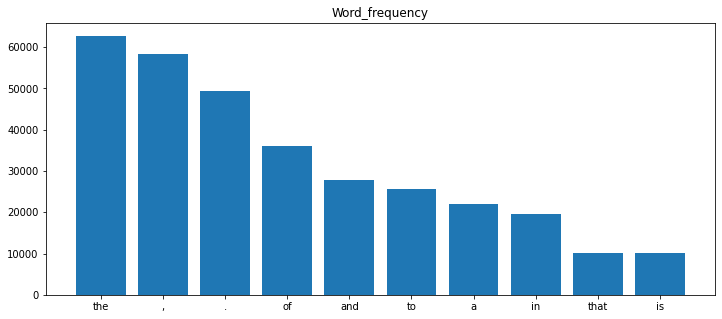

In [11]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [12]:
word_num['cat']

22

# Количество слова 'cat' в корпусе: 22

### Вопрос 2:
* Самое популярное слово с самым популярным тегом?

In [13]:
tag_num.keys()[0]

'NOUN'

In [14]:
print(brown_tagged_words)
word_tag_fd = nltk.FreqDist(brown_tagged_words)
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == tag_num.keys()[0]][0]

[('The', 'DET'), ('Fulton', 'NOUN'), ...]


'time'

# Самое популярное слово с самым популярным тегом: 'time'

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [15]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [17]:
my_brown_tagged_sents = np.array(brown.tagged_sents(tagset="universal", categories='humor'))
size = int(len(my_brown_tagged_sents) * 0.9)
c = []
for i in range(len(my_brown_tagged_sents)):
    if i < size:
        c.append(True)
    else:
        c.append(False)

np.random.seed(2)        
random_index = np.random.choice(c, len(c), replace = False).astype('bool')
train_sents = my_brown_tagged_sents[random_index]
test_sents = my_brown_tagged_sents[(1 - random_index).astype('bool')]
print(train_sents.shape)
print(test_sents.shape)

(947,)
(106,)


### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что, находясь в скрытом состоянии $s_i$,(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.


#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [18]:
class HiddenMarkovModel:    
    popular = ''
    def __init__(self):
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
        tag_num_v = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега с корпусе
        word_num_v = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова с корпусе
        ff = []
        for jj in  train_tokens_tags_list:
            for kk in jj:
                ff.append(kk)
       
        word_tag_fd = nltk.FreqDist(ff)
        aaq = [wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == tag_num_v.keys()[0]][0]
        self.popular = (aaq, tag_num_v.keys()[0])
        print(self.popular)
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0],sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self.popular[0]
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    #print(i_s)
                    s = self.tags[i_s]
                    #print(s)
                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t] *
                        self.A.loc[:, self.tags[i_s]] * 
                        self.B.loc[current_sent[t], s])
                    #print(q[t])
                    #print(self.A.loc[:, self.tags[i_s-1]])
                    #print(self.B.loc[current_sent[t], s])
                    
                    # argmax формула(1)
                    #print(q[t + 1][i_s])
                    #print(type((q[t] * self.A.loc[:, self.tags[i_s-1]] * self.B.loc[current_sent[t],s])))
                    #print(type((q[t] * self.A.loc[:, self.tags[i_s-1]] * self.B.loc[current_sent[t],s]).reset_index()))
                    #print((q[t] * self.A.loc[:, self.tags[i_s-1]] * self.B.loc[current_sent[t],s]).reset_index().columns)
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, self.tags[i_s]] * self.B.loc[current_sent[t],s]).reset_index()[s].astype('float').idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
            
        return predict_tags
                
        
                    

Обучите скрытую марковскую модель:

In [19]:
hidmm = HiddenMarkovModel()
hidmm.fit(train_sents)

('time', 'NOUN')


Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [20]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
hidmm.predict(sents)


OrderedDict([(0, array(['PRON', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['PRON', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['DET', 'NOUN', 'NOUN'], dtype='<U4'))])

# Результат очень точный. Ошибка только со словом favourite 

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [21]:
hidmm.predict([["can"]])

OrderedDict([(0, array(['VERB'], dtype='<U4'))])

# Тег для слова 'can': 'VERB'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [22]:
hidmm.predict([["favourite"]])

OrderedDict([(0, array(['NOUN'], dtype='<U4'))])

# Тег для слова 'favourite': 'NOUN'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [23]:
k_full = 0.0
k_right = 0.0
for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    words = words.astype('<U50')
    predict_tags = hidmm.predict([words])[0]
    k_right += np.sum(tags == predict_tags)
    k_full += len(tags)
print("Accuracy:", k_right / k_full * 100, '%')

Accuracy: 88.96680691912108 %


# Видим, что модель дала очень хороший результат!

### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [24]:
print("Accuracy:",round(k_right / k_full * 100,1), '%')

Accuracy: 89.0 %


## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения) или можете преобразовать код выше

In [25]:
k_full = 0.0
k_right = 0.0
for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    words = words.astype('<U50')
    k_right += np.sum(tags == "NOUN")
    k_full += len(tags)
print("Accuracy:", round(k_right / k_full * 100,1), '%')


Accuracy: 21.6 %


# Точность, если предсказывать любой тег, как самый популярный: 21.6 % - очень плохо

## Модель Стенфорда

Скачайте предобученную модель от Стэнфорда: https://nlp.stanford.edu/software/tagger.shtml и примените к тестовым данным. 
Не забудьте преобразовать систему тэгов из 'en-ptb' в 'universal' с помощью функции map_tag.

In [26]:
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tag.mapping import map_tag

# используйте путь до jar и до model
jar = '/Users/rozasamyrkanova/Downloads/stanford-postagger-2018-10-16/stanford-postagger-3.9.2.jar'
model = '/Users/rozasamyrkanova/Downloads/stanford-postagger-2018-10-16/models/english-bidirectional-distsim.tagger'
stanford_tagger = StanfordPOSTagger(model, jar, encoding='utf8')


# проверим на предложении
tagged_sent = stanford_tagger.tag(['I', 'bear', 'a', 'bag'])
print('Ответ: ', [map_tag('en-ptb', 'universal',  tag) for token, tag in tagged_sent])

Ответ:  ['PRON', 'VERB', 'DET', 'NOUN']


### Вопрос 7:
* Какое качество вы получили на модели Стенфорда(округлите до одного знака после запятой)?

In [27]:
k_full = 0.0
k_right = 0.0
for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    words = words.astype('<U50')
    tagged_sent = stanford_tagger.tag(words)
    new_tag = [map_tag('en-ptb', 'universal',  tag) for token, tag in tagged_sent]
    k_right += np.sum(tags == new_tag)
    k_full += len(tags)
print("Accuracy:", round(k_right / k_full * 100,1), '%')

Accuracy: 90.4 %


## Сравните результаты моделей

# Модель Стенфорда подошла лучше

# Результат модели Стенфорда: 90.4 %

# Результат скрытой марковской модели: 89.0 %

# Результат предсказания любого тега, как самого популярного: 21.6 % 